# 1. Import modules

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")
plt.rcParams["figure.facecolor"] = "white"

home_dir = os.path.expanduser("~")
local_dir = f"{home_dir}/Documents/github/CIV1498/projects/project2"
github_dir = f"{home_dir}/Documents/github/CIV1498-Project2"

# 2. Import dataframe

In [64]:
df_LA_parcels_LAcity_cleaned_REV3 = pd.read_pickle(f"{github_dir}/dataframes/df_LA_parcels_LAcity_cleaned_REV3_MB.pkl", compression="gzip")

# 3. See where parcels are located and average TotalValue for each neighborhood

In [11]:
gdf_LA_county_boundaries = gpd.read_file(f"{local_dir}/geographic/LA_County_City_Boundaries.shp")["geometry"]
gdf_LA_city_neigborhoods = gpd.read_file(f"{local_dir}/geographic/cfbcc20d-2c5d-4c30-9dfa-627d46ec1a742020328-1-9ulknm.pzqsm.shp")

plot_data = gdf_LA_city_neigborhoods.set_axis(["OBJECTID", "Neighborhood", "geometry"], axis=1).merge(df_LA_parcels_LAcity_cleaned_REV3.groupby("Neighborhood").mean().reset_index()[["TotalValue", "Neighborhood"]], how="left", on="Neighborhood")[["Neighborhood", "TotalValue"]]

plot_geography = gdf_LA_city_neigborhoods.set_axis(["OBJECTID", "Neighborhood", "geometry"], axis=1).merge(df_LA_parcels_LAcity_cleaned_REV3.groupby("Neighborhood").mean().reset_index()[["TotalValue", "Neighborhood"]], how="left", on="Neighborhood")[["Neighborhood", "geometry"]].set_index("Neighborhood")

import folium
from folium import Choropleth
map_1 = folium.Map(location=[34.052235, -118.243683], 
                   tiles='cartodbpositron',
                   zoom_start=10)

# Add a choropleth map to the base map
Choropleth(geo_data=gdf_LA_county_boundaries.__geo_interface__,
           fill_color="gray").add_to(map_1)
           
Choropleth(geo_data=plot_geography.__geo_interface__, 
           columns=["Neighborhood", "TotalValue"],
           data=plot_data, 
           key_on='feature.id', 
           fill_color='YlOrRd', 
           legend_name='Average TotalValue of Parcels in Neighborhood (USD)',
          ).add_to(map_1)

# Display the map
map_1.save(outfile=f"{github_dir}/figures/MB/Selected_parcels_in_LAcity_Choropleth.html")

# 4. Cluster neighborhoods based on TotalValue

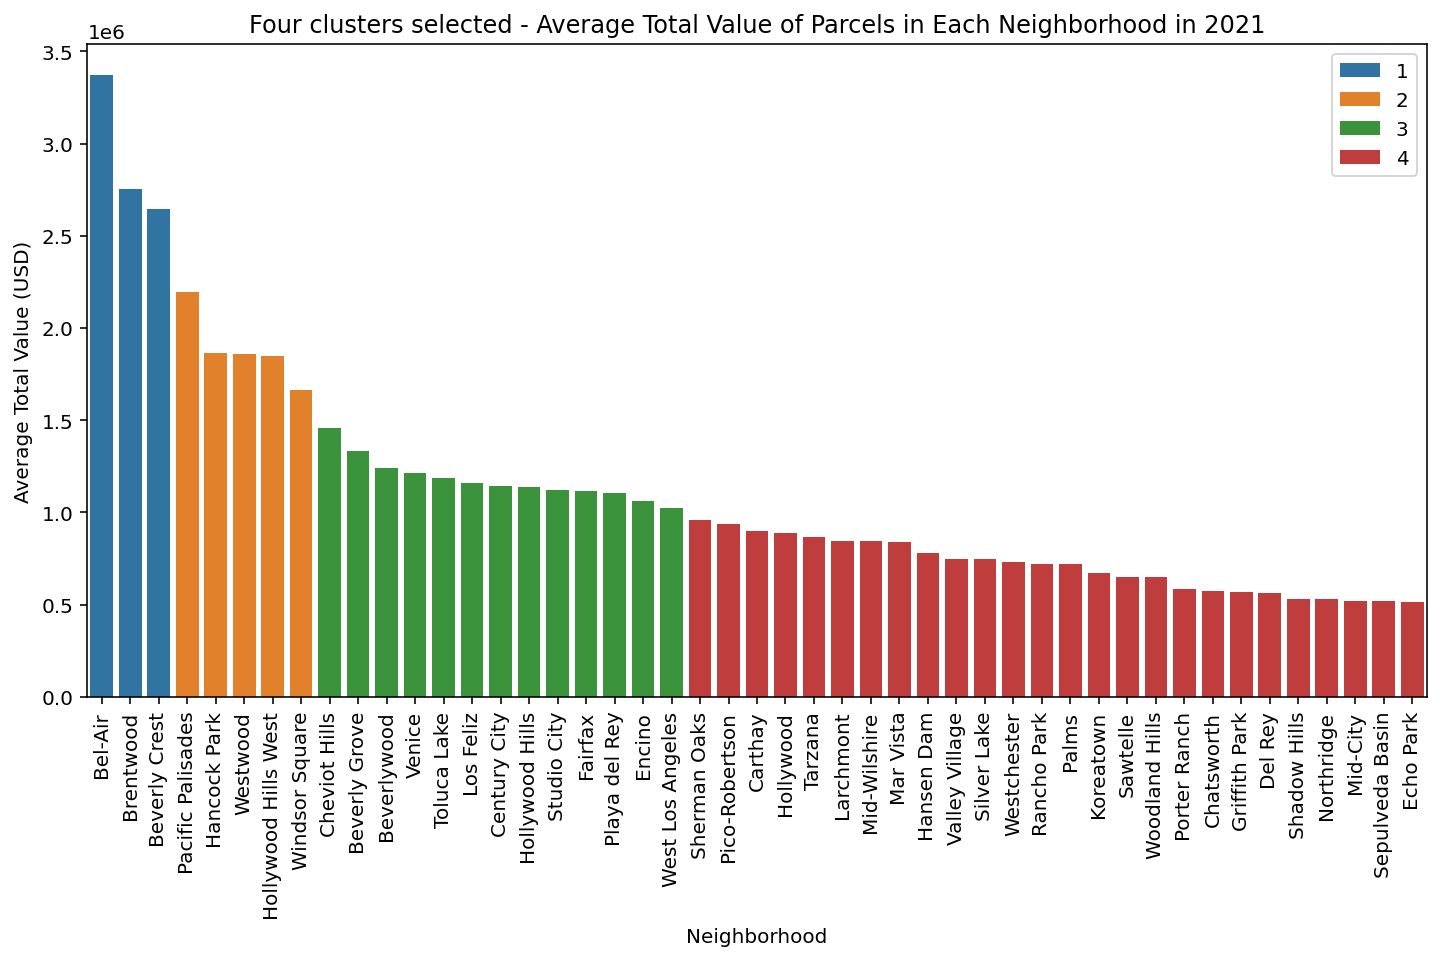

In [74]:
df_LA_parcels_LAcity_cleaned_REV3_cluster = df_LA_parcels_LAcity_cleaned_REV3.groupby("Neighborhood").mean().sort_values("TotalValue", ascending=False).reset_index()[["Neighborhood", "TotalValue"]]

df_LA_parcels_LAcity_cleaned_REV3_cluster["cluster"] = np.nan
df_LA_parcels_LAcity_cleaned_REV3_cluster.loc[0:3, "cluster"] = "1"
df_LA_parcels_LAcity_cleaned_REV3_cluster.loc[3:8, "cluster"] = "2"
df_LA_parcels_LAcity_cleaned_REV3_cluster.loc[8:21, "cluster"] = "3"
df_LA_parcels_LAcity_cleaned_REV3_cluster.loc[21:, "cluster"] = "4"

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df_LA_parcels_LAcity_cleaned_REV3_cluster.iloc[:47], x="Neighborhood", y="TotalValue", hue="cluster", dodge=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=10)
ax.set_title("Four clusters selected - Average Total Value of Parcels in Each Neighborhood in 2021")
ax.set_xlabel("Neighborhood")
ax.set_ylabel("Average Total Value (USD)")
plt.legend(loc="upper right")
plt.savefig(f"{github_dir}/figures/MB/Selected_parcels_in_LAcity_cluster.png", bbox_inches="tight", dpi=300)

# 5. Clusters on the map

In [ ]:
gdf_LA_city_neigborhoods = gpd.read_file(f"{local_dir}/geographic/cfbcc20d-2c5d-4c30-9dfa-627d46ec1a742020328-1-9ulknm.pzqsm.shp")

# Plot neighborhood boundaries in LA City
ax = gdf_LA_city_neigborhoods.plot(figsize=(16, 9), categorical=True, linewidth=0.5, edgecolor="0.2", alpha=1.0, color="white", legend=False)

# Add parcels to the plot above
gdf_groupped = gdf_LA_city_neigborhoods.set_axis(["OBJECTID", "Neighborhood", "geometry"], axis=1).merge(df_LA_parcels_LAcity_cleaned_REV3.groupby("Neighborhood").mean().reset_index()[["TotalValue", "Neighborhood"]], how="left", on="Neighborhood").merge(df_LA_parcels_LAcity_cleaned_REV3_cluster, how="left", on="Neighborhood")

gdf_groupped.plot(ax=ax, categorical=False, column="cluster", cmap="OrRd_r", markersize=1, legend=True, **{"linewidth":2})

plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14) 
plt.title("Core is more expensive than other parts of the city", fontsize=16)
plt.savefig(f"{github_dir}/figures/MB/Selected_parcels_in_LAcity_cluster_on_map.png", dpi=600, bbox_inches="tight")

# Save dataframe to share
df_LA_parcels_LAcity_cleaned_REV3_cluster.to_pickle(f"{github_dir}/dataframes/neighborhoods_cluster.pkl")

# 6. Read the whole dataset for exploratory data analysis

In [96]:
index_EDA = pd.read_pickle(f"{local_dir}/index/Residential_SFR_Unit1_1Building_Regular_Private_LACity_index.pkl")

df_LA_parcels_AIN = pd.read_pickle(f"{local_dir}/dataframe/df_LA_parcels_AIN.pkl").loc[index_EDA]
df_LA_parcels_LandValue = pd.read_pickle(f"{local_dir}/dataframe/df_LA_parcels_LandValue.pkl").loc[index_EDA]
df_LA_parcels_LandValue["LandValue"] = df_LA_parcels_LandValue["LandValue"].str.replace(",", "").astype(float)
df_LA_parcels_RollYear = pd.read_pickle(f"{local_dir}/dataframe/df_LA_parcels_RollYear.pkl").loc[index_EDA]
df_LA_parcels_LandBaseYear = pd.read_pickle(f"{local_dir}/dataframe/df_LA_parcels_LandBaseYear.pkl").loc[index_EDA]
df_LA_parcels_TotalValue = pd.read_pickle(f"{local_dir}/dataframe/df_LA_parcels_TotalValue.pkl").loc[index_EDA]
df_LA_parcels_TotalValue["TotalValue"] = df_LA_parcels_TotalValue["TotalValue"].str.replace(",", "").astype(float)
df_LA_parcels_SQFTmain = pd.read_pickle(f"{local_dir}/dataframe/df_LA_parcels_SQFTmain.pkl").loc[index_EDA]
df_LA_parcels_SQFTmain["SQFTmain"] = df_LA_parcels_SQFTmain["SQFTmain"].str.replace(",", "").astype(float)
# df_LA_parcels_Bedrooms = pd.read_pickle(f"{local_dir}/dataframe/df_LA_parcels_Bedrooms.pkl").loc[index_final]
# df_LA_parcels_Bathrooms = pd.read_pickle(f"{local_dir}/dataframe/df_LA_parcels_Bathrooms.pkl").loc[index_final]
# df_LA_parcels_PropertyUseCode = pd.read_pickle(f"{local_dir}/dataframe/df_LA_parcels_PropertyUseCode.pkl").loc[index_final].astype(str)
# df_LA_parcels_YearBuilt = pd.read_pickle(f"{local_dir}/dataframe/df_LA_parcels_YearBuilt.pkl").loc[index_final]
# df_LA_parcels_EffectiveYearBuilt = pd.read_pickle(f"{local_dir}/dataframe/df_LA_parcels_EffectiveYearBuilt.pkl").loc[index_final]
# df_LA_parcels_TaxRateArea = pd.read_pickle(f"{local_dir}/dataframe/df_LA_parcels_TaxRateArea.pkl").loc[index_final]
# df_LA_parcels_Cluster = pd.read_pickle(f"{local_dir}/dataframe/df_LA_parcels_Cluster.pkl").loc[index_final]
# df_LA_parcels_ZIPcode = pd.read_pickle(f"{local_dir}/dataframe/df_LA_parcels_ZIPcode.pkl").loc[index_final]
# df_LA_parcels_ZIPcode[["ZIPcode5","ZIPcode4"]] = df_LA_parcels_ZIPcode["ZIPcode"].str.split('-', expand=True)
# df_LA_parcels_ZIPcode = df_LA_parcels_ZIPcode.drop(columns=["ZIPcode"]).astype({"ZIPcode5": "int64"})
# df_LAcity_parcels_closest_distance_BusSubway = pd.read_pickle(f"{local_dir}/dataframe/df_LAcity_parcels_closest_distance_BusSubway.pkl")
df_LAcity_parcels_neighborhood = pd.read_pickle(f"{local_dir}/dataframe/df_LAcity_parcels_neighborhood.pkl").merge(pd.read_pickle(f"{local_dir}/dataframe/df_LA_parcels_AIN.pkl").loc[pd.read_pickle(f"{local_dir}/index/Residential_SFR_Unit1_1Building_Regular_Private_LACity_Roll2021_closest_distance_BusSubway_index.pkl")], left_index=True, right_index=True)

parcel_boundaries_LA_cleaned = pd.read_pickle(f"{local_dir}/geographic/parcel_boundaries_LA_cleaned.pkl")

df_LAcity_parcels_EDA = pd.concat([df_LA_parcels_AIN,
                                   df_LA_parcels_RollYear,
                                   df_LA_parcels_SQFTmain,
                                   df_LA_parcels_TotalValue,
                                   df_LA_parcels_LandBaseYear,
                                   df_LA_parcels_LandValue
                                  ], axis=1).merge(df_LAcity_parcels_neighborhood, how="left", on="AIN")\
                                            .merge(parcel_boundaries_LA_cleaned, how="left", on="AIN")

df_LAcity_parcels_EDA = df_LAcity_parcels_EDA.dropna(subset=["Neighborhood"])
df_LAcity_parcels_EDA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6986353 entries, 3464 to 10400126
Data columns (total 10 columns):
 #   Column        Dtype   
---  ------        -----   
 0   AIN           int64   
 1   RollYear      int64   
 2   SQFTmain      float64 
 3   TotalValue    float64 
 4   LandBaseYear  int64   
 5   LandValue     float64 
 6   Neighborhood  object  
 7   ShapeSTAre    float64 
 8   ShapeSTLen    float64 
 9   geometry      geometry
dtypes: float64(5), geometry(1), int64(3), object(1)
memory usage: 586.3+ MB


In [3]:
df_LA_parcels_AIN = pd.read_pickle(f"{local_dir}/dataframe/df_LA_parcels_AIN.pkl")
df_LA_parcels_AIN.nunique()

AIN    2485732
dtype: int64

# 7.1. Find out how many times a parcel has been sold over 15 years

In [92]:
unique_AINs = df_LAcity_parcels_EDA["AIN"].unique()
numberSold = []
series_dummy = df_LAcity_parcels_EDA.groupby("AIN")["LandBaseYear"].nunique()
for i, AIN in enumerate(unique_AINs):
    numberSold.append(series_dummy.loc[AIN])

numberSold = pd.Series(numberSold, index=unique_AINs).subtract(1).to_frame("NumberSold").reset_index().set_axis(["AIN", "NumberSold"], axis=1)
numberSold.to_pickle(f"{local_dir}/dataframe/df_LAcity_parcels_numberSold.pkl")
numberSold.to_pickle(f"{github_dir}/dataframes/df_LAcity_parcels_numberSold.pkl")

## 7.2. Compare Average Total Value for each year

In [34]:
df_average_annually = pd.DataFrame(index=np.arange(2006, 2022, dtype=int), columns=["TotalValue", "TotalValueSold", "Ratio", "Count", "CountSold", "Percentage"])

for selected_year in np.arange(2006, 2022, dtype=int):
        
    # f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=6, ncols=1, sharex=True, figsize=(40, 24))

    df_ax1 = df_LAcity_parcels_EDA[df_LAcity_parcels_EDA["RollYear"] == selected_year].groupby("Neighborhood").agg({"TotalValue": "mean"}).sort_values(by="TotalValue", ascending=False).div(1e6).reset_index()
    # df_ax1.plot(ax=ax1, kind="bar", x="Neighborhood", y="TotalValue", legend=False, color="darkgreen")

    index_ax1 = df_LAcity_parcels_EDA[df_LAcity_parcels_EDA["RollYear"] == selected_year].groupby("Neighborhood").agg({"TotalValue": "mean"}).sort_values(by="TotalValue", ascending=False).index

    df_ax2 = df_LAcity_parcels_EDA[(df_LAcity_parcels_EDA["RollYear"] == selected_year) & (df_LAcity_parcels_EDA["LandBaseYear"] == selected_year)].groupby("Neighborhood").agg({"TotalValue": "mean"}).reindex(index_ax1).div(1e6).reset_index()

    # df_ax2.plot(ax=ax2, kind="bar", x="Neighborhood", y="TotalValue", legend=False, color="green")

    df_ax3 = df_ax2.copy()
    df_ax3["TotalValue"] = df_ax3["TotalValue"] / df_ax1["TotalValue"]

    # df_ax3.plot(ax=ax3, kind="bar", x="Neighborhood", y="TotalValue", legend=False, color="limegreen")

    df_ax4 = df_LAcity_parcels_EDA[df_LAcity_parcels_EDA["RollYear"] == selected_year].groupby("Neighborhood").agg({"AIN": "count"}).reindex(index_ax1).div(1e3).reset_index().set_axis(["Neighborhood", "Count"], axis=1)

    # df_ax4.plot(ax=ax4, kind="bar", x="Neighborhood", y="Count", legend=False, color="steelblue")

    df_ax5 = df_LAcity_parcels_EDA[(df_LAcity_parcels_EDA["RollYear"] == selected_year) & (df_LAcity_parcels_EDA["LandBaseYear"] == selected_year)].groupby("Neighborhood").agg({"AIN": "count"}).reindex(index_ax1).div(1e3).reset_index().set_axis(["Neighborhood", "Count"], axis=1)

    # df_ax5.plot(ax=ax5, kind="bar", x="Neighborhood", y="Count", legend=False, color="dodgerblue")

    df_ax6 = df_ax5.copy()
    df_ax6["Count"] = df_ax6["Count"] / df_ax4["Count"] * 100
    # df_ax6.plot(ax=ax6, kind="bar", x="Neighborhood", y="Count", legend=False, color="deepskyblue")


    df_average_annually.loc[selected_year, "TotalValue"] = df_ax1["TotalValue"].mean()
    df_average_annually.loc[selected_year, "TotalValueSold"] = df_ax2["TotalValue"].mean()
    df_average_annually.loc[selected_year, "Ratio"] = df_ax3["TotalValue"].mean()
    df_average_annually.loc[selected_year, "Count"] = df_ax4["Count"].mean()
    df_average_annually.loc[selected_year, "CountSold"] = df_ax5["Count"].mean()
    df_average_annually.loc[selected_year, "Percentage"] = df_ax6["Count"].mean()

    # ax1.axhline(y=df_ax1["TotalValue"].mean(), ls='--', color="red", label="Mean = {:.2f}".format(df_ax1["TotalValue"].mean()))
    # ax2.axhline(y=df_ax2["TotalValue"].mean(), ls='--', color="red", label="Mean = {:.2f}".format(df_ax2["TotalValue"].mean()))
    # ax3.axhline(y=df_ax3["TotalValue"].mean(), ls='--', color="red", label="Mean = {:.2f}".format(df_ax3["TotalValue"].mean()))
    # ax4.axhline(y=df_ax4["Count"].mean(), ls='--', color="red", label="Mean = {:.2f}".format(df_ax4["Count"].mean()))
    # ax5.axhline(y=df_ax5["Count"].mean(), ls='--', color="red", label="Mean = {:.2f}".format(df_ax5["Count"].mean()))
    # ax6.axhline(y=df_ax6["Count"].mean(), ls='--', color="red", label="Mean = {:.2f}".format(df_ax6["Count"].mean()))
    # ax1.legend(loc="upper right")
    # ax2.legend(loc="upper right")
    # ax3.legend(loc="upper right")
    # ax4.legend(loc="upper right")
    # ax5.legend(loc="upper right")
    # ax6.legend(loc="upper right")
    # ax1.set_ylabel("Total Value (USD in Millions)")
    # ax2.set_ylabel("Total Value (USD in Millions)")
    # ax3.set_ylabel("Ratio of Total Value")
    # ax4.set_ylabel("The Number of Parcels (Thousands)")
    # ax5.set_ylabel("The Number of Parcels (Thousands)")
    # ax6.set_ylabel("Percentage of Parels")

    # ax1.set_title(f"Average Total Value of Parcels in LA City in {selected_year}")
    # ax2.set_title(f"Average Total Value of Parcels in LA City Sold in {selected_year}")
    # ax3.set_title(f"Ratio of Average Total Value to Average Total Value of Parcels Sold in {selected_year}")
    # ax4.set_title(f"The Number of Parcels in LA City")
    # ax5.set_title(f"The Number of Parcels in LA City Sold in {selected_year}")
    # ax6.set_title(f"Percentage of Parcels Sold in {selected_year}");
    # for ax in f.axes:
    #     ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

    # plt.savefig(f"{github_dir}/figures/MB/EDA/LA_city_parcels_overview_{selected_year}.png", dpi=300, bbox_inches="tight")

df_average_annually.to_pickle(f"{local_dir}/dataframe/LA_city_parcels_overview_average_annually.pkl")

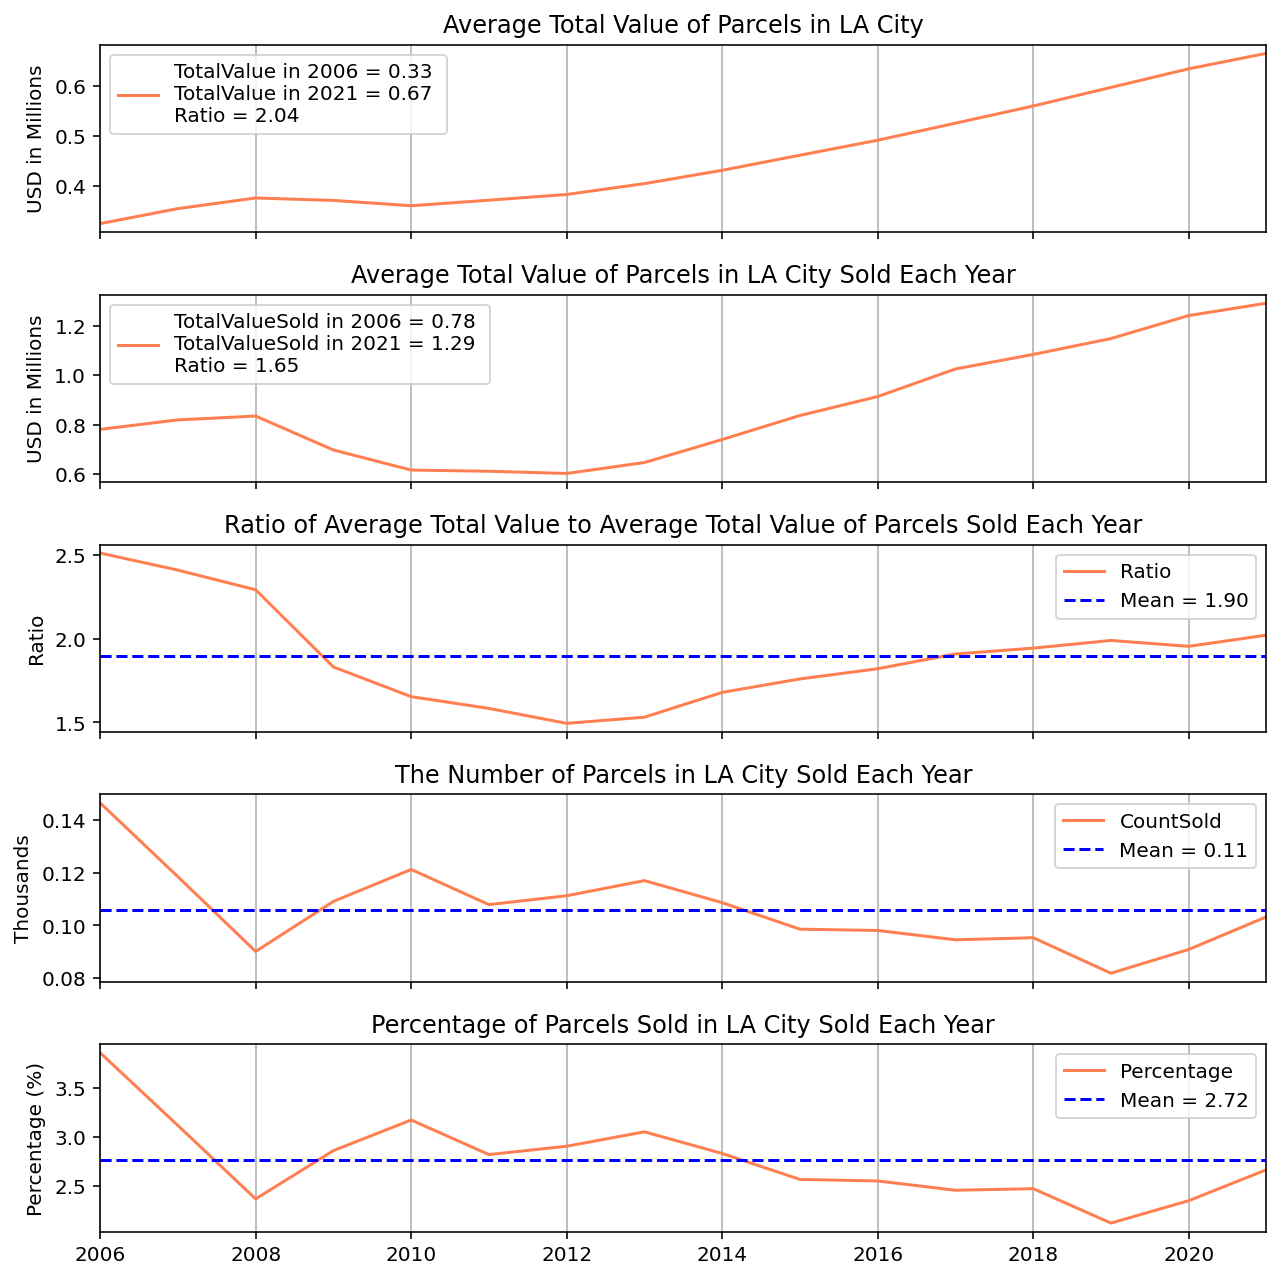

In [105]:
df_average_annually = pd.read_pickle(f"{local_dir}/dataframe/LA_city_parcels_overview_average_annually.pkl")

f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=5, ncols=1, sharex=True, figsize=(9, 9))

ax1.plot(df_average_annually.index, df_average_annually["TotalValue"], label=f"TotalValue in 2006 = {round(df_average_annually['TotalValue'][2006], 2)} \nTotalValue in 2021 = {round(df_average_annually['TotalValue'][2021], 2)} \nRatio = {round(df_average_annually['TotalValue'][2021]/df_average_annually['TotalValue'][2006], 2)}", color="coral")
ax2.plot(df_average_annually.index, df_average_annually["TotalValueSold"], label=f"TotalValueSold in 2006 = {round(df_average_annually['TotalValueSold'][2006], 2)} \nTotalValueSold in 2021 = {round(df_average_annually['TotalValueSold'][2021], 2)} \nRatio = {round(df_average_annually['TotalValueSold'][2021]/df_average_annually['TotalValueSold'][2006], 2)}", color="coral")
ax3.plot(df_average_annually.index, df_average_annually["Ratio"], label="Ratio", color="coral")
ax3.axhline(y=df_average_annually["Ratio"].mean(), ls='--', color="blue", label="Mean = {:.2f}".format(df_average_annually["Ratio"].mean()))
# ax4.plot(df_average_annually.index, df_average_annually["Count"], label="Count")
ax4.plot(df_average_annually.index, df_average_annually["CountSold"], label="CountSold", color="coral")
percentage = df_average_annually["CountSold"] / df_average_annually["Count"] * 100
ax5.plot(df_average_annually.index, percentage, label="Percentage", color="coral")
ax4.axhline(y=df_average_annually["CountSold"].mean(), ls='--', color="blue", label="Mean = {:.2f}".format(df_average_annually["CountSold"].mean()))
ax5.axhline(y=percentage.mean(), ls='--', color="blue", label="Mean = {:.2f}".format(df_average_annually["Percentage"].mean()))
ax1.set_ylabel("USD in Millions")
ax2.set_ylabel("USD in Millions")
ax3.set_ylabel("Ratio")
ax4.set_ylabel("Thousands")
ax5.set_ylabel("Percentage (%)")
ax1.set_title("Average Total Value of Parcels in LA City")
ax2.set_title("Average Total Value of Parcels in LA City Sold Each Year")
ax3.set_title("Ratio of Average Total Value to Average Total Value of Parcels Sold Each Year")
ax4.set_title("The Number of Parcels in LA City Sold Each Year")
ax5.set_title("Percentage of Parcels Sold in LA City Sold Each Year")
ax1.legend(loc="best")
ax2.legend(loc="best")
ax3.legend(loc="best")
ax4.legend(loc="best")
ax5.legend(loc="best")
ax1.grid(axis="x")
ax2.grid(axis="x")
ax3.grid(axis="x")
ax4.grid(axis="x")
ax5.grid(axis="x")
ax1.set_xlim(left=df_average_annually.index[0], right=df_average_annually.index[-1])

plt.tight_layout()
plt.savefig(f"{github_dir}/figures/MB/EDA/LA_city_parcels_overview_average_annually.png", dpi=300, bbox_inches="tight")

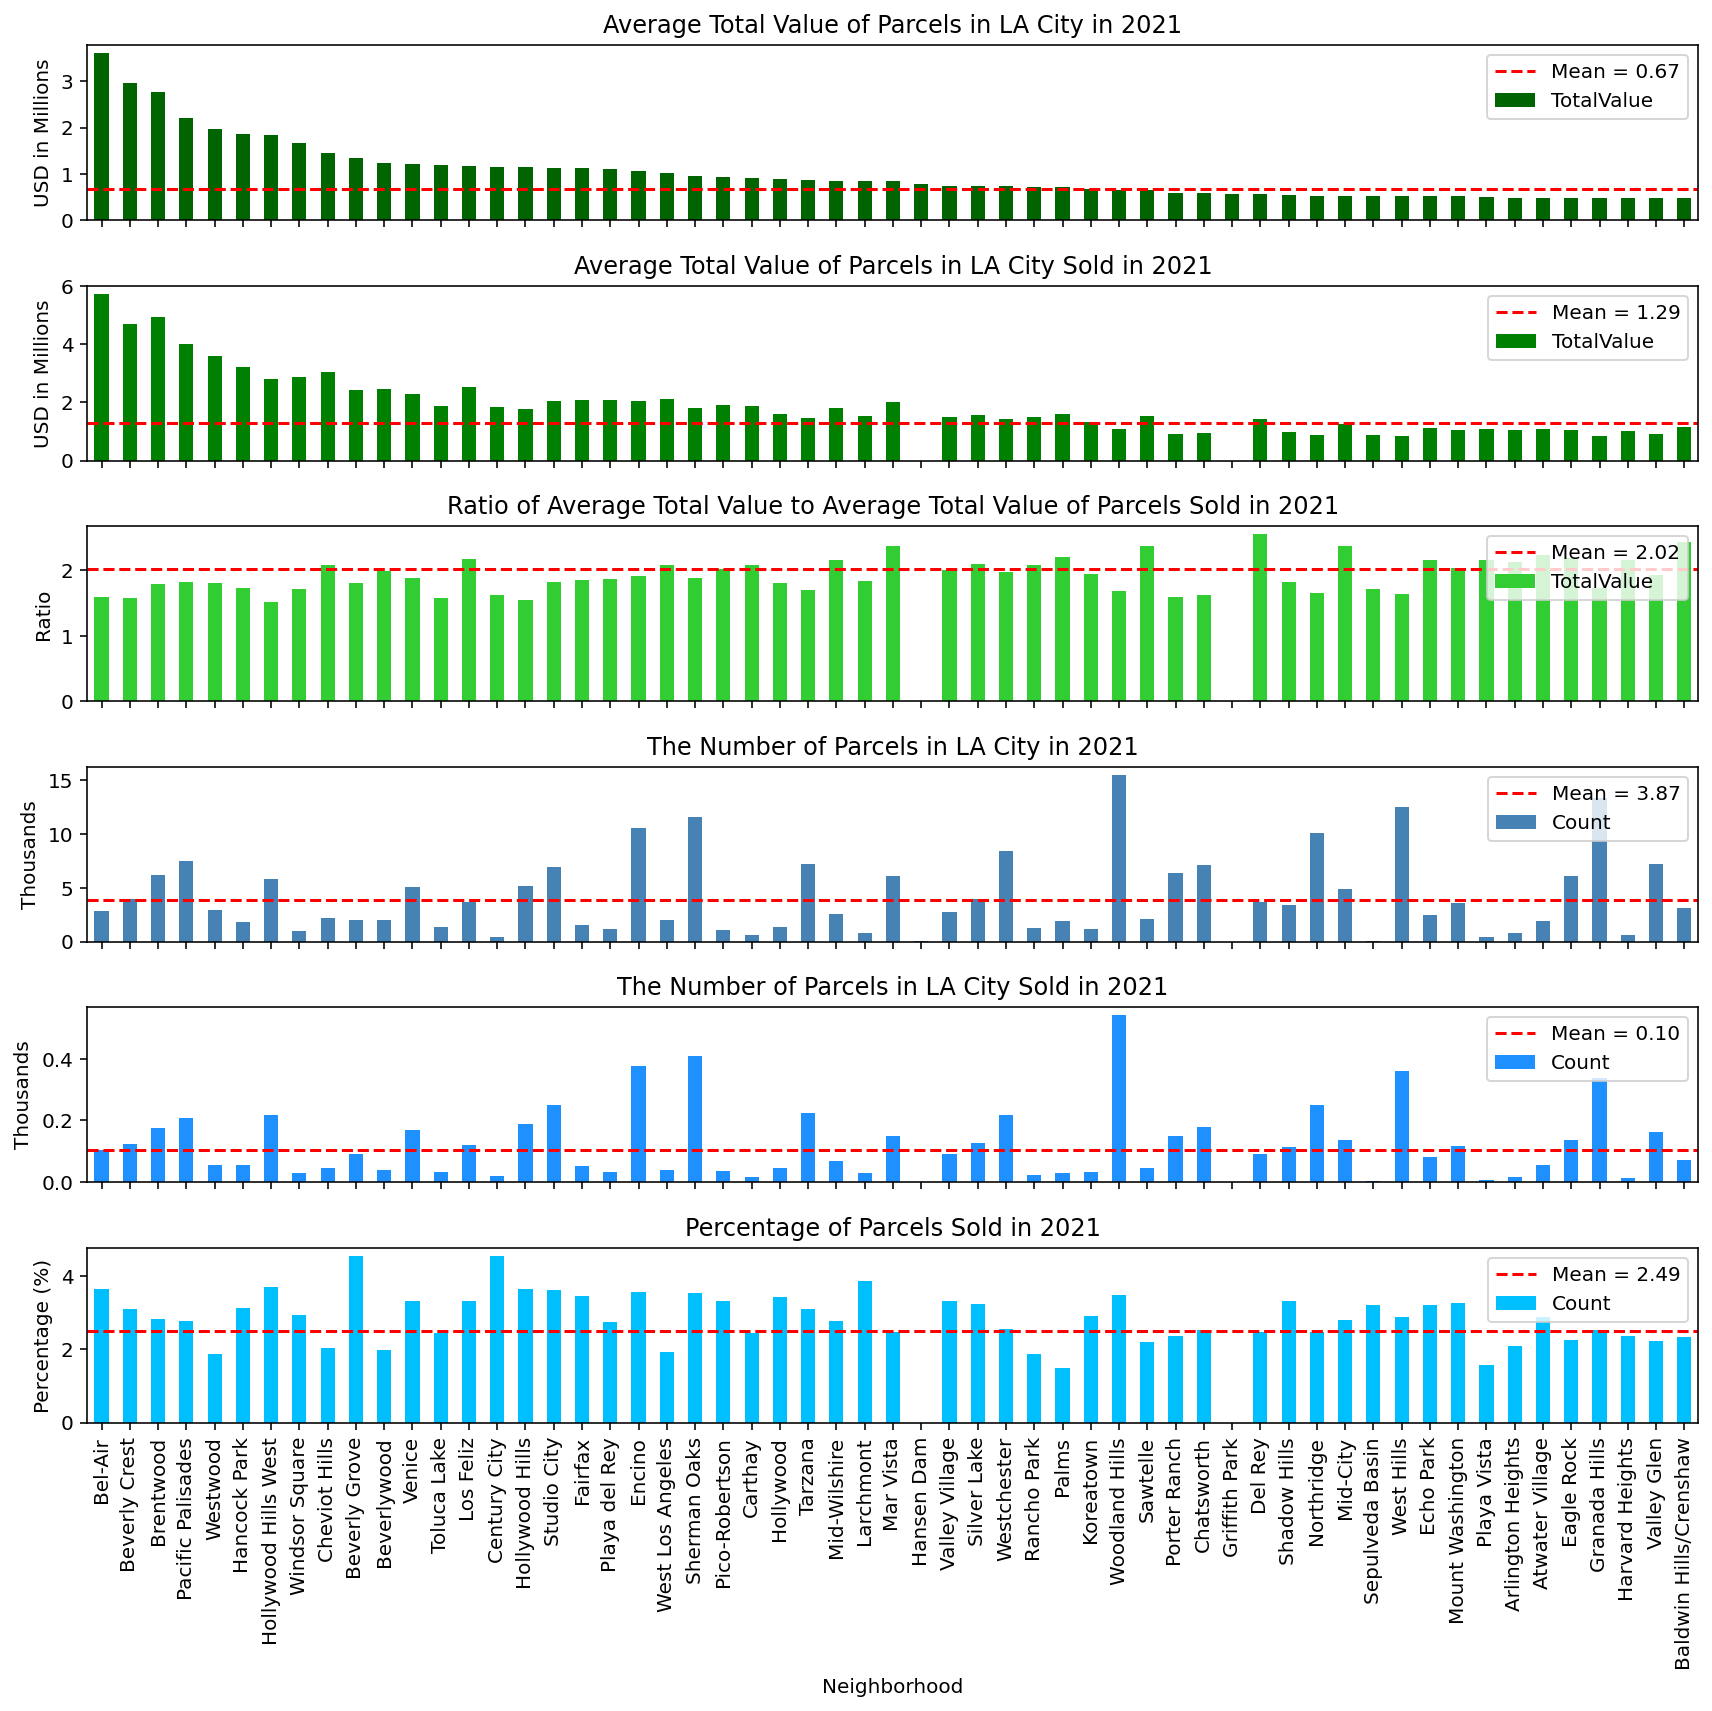

In [77]:
selected_year = 2021
idx = df_LAcity_parcels_EDA["Neighborhood"].nunique()
# for selected_year in np.arange(2006, 2022, dtype=int):

start_index = 0
end_index = int(idx / 2)

# start_index = int(idx /2)
# end_index = int(idx + 1)

f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=6, ncols=1, sharex=True, figsize=(12, 12))

df_ax1 = df_LAcity_parcels_EDA[df_LAcity_parcels_EDA["RollYear"] == selected_year].groupby("Neighborhood").agg({"TotalValue": "mean"}).sort_values(by="TotalValue", ascending=False).div(1e6).reset_index()
df_ax1.iloc[start_index:end_index].plot(ax=ax1, kind="bar", x="Neighborhood", y="TotalValue", legend=False, color="darkgreen")

index_ax1 = df_LAcity_parcels_EDA[df_LAcity_parcels_EDA["RollYear"] == selected_year].groupby("Neighborhood").agg({"TotalValue": "mean"}).sort_values(by="TotalValue", ascending=False).index

df_ax2 = df_LAcity_parcels_EDA[(df_LAcity_parcels_EDA["RollYear"] == selected_year) & (df_LAcity_parcels_EDA["LandBaseYear"] == selected_year)].groupby("Neighborhood").agg({"TotalValue": "mean"}).reindex(index_ax1).div(1e6).reset_index()

df_ax2.iloc[start_index:end_index].plot(ax=ax2, kind="bar", x="Neighborhood", y="TotalValue", legend=False, color="green")

df_ax3 = df_ax2.copy()
df_ax3["TotalValue"] = df_ax3["TotalValue"] / df_ax1["TotalValue"]

df_ax3.iloc[start_index:end_index].plot(ax=ax3, kind="bar", x="Neighborhood", y="TotalValue", legend=False, color="limegreen")

df_ax4 = df_LAcity_parcels_EDA[df_LAcity_parcels_EDA["RollYear"] == 2021].groupby("Neighborhood").agg({"AIN": "count"}).reindex(index_ax1).div(1e3).reset_index().set_axis(["Neighborhood", "Count"], axis=1)

df_ax4.iloc[start_index:end_index].plot(ax=ax4, kind="bar", x="Neighborhood", y="Count", legend=False, color="steelblue")

df_ax5 = df_LAcity_parcels_EDA[(df_LAcity_parcels_EDA["RollYear"] == 2021) & (df_LAcity_parcels_EDA["LandBaseYear"] == 2021)].groupby("Neighborhood").agg({"AIN": "count"}).reindex(index_ax1).div(1e3).reset_index().set_axis(["Neighborhood", "Count"], axis=1)

df_ax5.iloc[start_index:end_index].plot(ax=ax5, kind="bar", x="Neighborhood", y="Count", legend=False, color="dodgerblue")

df_ax6 = df_ax5.copy()
df_ax6["Count"] = df_ax6["Count"] / df_ax4["Count"] * 100
df_ax6.iloc[start_index:end_index].plot(ax=ax6, kind="bar", x="Neighborhood", y="Count", legend=False, color="deepskyblue")

ax1.axhline(y=df_ax1["TotalValue"].mean(), ls='--', color="red", label="Mean = {:.2f}".format(df_ax1["TotalValue"].mean()))
ax2.axhline(y=df_ax2["TotalValue"].mean(), ls='--', color="red", label="Mean = {:.2f}".format(df_ax2["TotalValue"].mean()))
ax3.axhline(y=df_ax3["TotalValue"].mean(), ls='--', color="red", label="Mean = {:.2f}".format(df_ax3["TotalValue"].mean()))
ax4.axhline(y=df_ax4["Count"].mean(), ls='--', color="red", label="Mean = {:.2f}".format(df_ax4["Count"].mean()))
ax5.axhline(y=df_ax5["Count"].mean(), ls='--', color="red", label="Mean = {:.2f}".format(df_ax5["Count"].mean()))
ax6.axhline(y=df_ax6["Count"].mean(), ls='--', color="red", label="Mean = {:.2f}".format(df_ax6["Count"].mean()))
ax1.legend(loc="upper right")
ax2.legend(loc="upper right")
ax3.legend(loc="upper right")
ax4.legend(loc="upper right")
ax5.legend(loc="upper right")
ax6.legend(loc="upper right")
ax1.set_ylabel("USD in Millions")
ax2.set_ylabel("USD in Millions")
ax3.set_ylabel("Ratio")
ax4.set_ylabel("Thousands")
ax5.set_ylabel("Thousands")
ax6.set_ylabel("Percentage (%)")

ax1.set_title(f"Average Total Value of Parcels in LA City in {selected_year}")
ax2.set_title(f"Average Total Value of Parcels in LA City Sold in {selected_year}")
ax3.set_title(f"Ratio of Average Total Value to Average Total Value of Parcels Sold in {selected_year}")
ax4.set_title(f"The Number of Parcels in LA City in {selected_year}")
ax5.set_title(f"The Number of Parcels in LA City Sold in {selected_year}")
ax6.set_title(f"Percentage of Parcels Sold in {selected_year}");
for ax in f.axes:
    ax.set_xticklabels(ax.get_xticklabels())

plt.tight_layout()
# plt.savefig(f"{github_dir}/figures/MB/EDA/LA_city_parcels_overview_{selected_year}_range_{start_index}_{end_index-1}.png", dpi=300, bbox_inches="tight")

In [95]:
df_ax6.sort_values("Count", ascending=True).tail(10)

Neighborhood     Count
0                 Bel-Air  3.656372
6    Hollywood Hills West  3.714481
27              Larchmont  3.879850
9           Beverly Grove  4.547751
14           Century City  4.555315
29             Hansen Dam       NaN
40          Griffith Park       NaN
61   Chatsworth Reservoir       NaN
79              Chinatown       NaN
102              Downtown       NaN

## 7.3. Average Total Value For Each Neighborhood

In [ ]:
for i, list_of_neighborhoods in enumerate(np.array_split(df_LAcity_parcels_EDA["Neighborhood"].unique(), 4)):
    nrows = len(list_of_neighborhoods)
    f, ax = plt.subplots(nrows=nrows, ncols=2, sharex=True, figsize=(12, 4))
    
    for j, neighborhood in enumerate(list_of_neighborhoods):

        df_ax1 = df_LAcity_parcels_EDA[df_LAcity_parcels_EDA["Neighborhood"] == neighborhood].groupby("RollYear").agg({"TotalValue": "mean"}).div(1e6).reset_index()
        df_ax1.plot(kind="line", x="RollYear", y="TotalValue", legend=False, color="green", ax=ax[j, 0])

        df_ax2 = df_LAcity_parcels_EDA[df_LAcity_parcels_EDA["Neighborhood"] == neighborhood].groupby("RollYear").agg({"AIN": "count"}).div(1e3).reset_index().set_axis(["RollYear", "Count"], axis=1)
        df_ax2.plot(kind="line", x="RollYear", y="Count", legend=False, color="dodgerblue", ax=ax[j, 1])

        ax[j, 0].axhline(y=df_ax1["TotalValue"].mean(), ls='--', color="red", label="Mean = {:.2f}".format(df_ax1["TotalValue"].mean()))
        ax[j, 1].axhline(y=df_ax2["Count"].mean(), ls='--', color="red", label="Mean = {:.2f}".format(df_ax2["Count"].mean()))
        ax[j, 0].legend()
        ax[j, 1].legend()
        ax[j, 0].set_ylabel("Total Value (USD in Millions)")
        ax[j, 1].set_ylabel("The Number of Parcels Sold (Thousands)")
        ax[j, 0].set_xlabel("Roll Year")
        ax[j, 1].set_xlabel("Roll Year")
        ax[j, 0].set_title(f"Average Total Value of Parcels in {neighborhood}")
        ax[j, 1].set_title(f"The Number of Parcels in {neighborhood}")
        ax[j, 0].grid(axis="y")
        ax[j, 1].grid(axis="y")
    
    # f.suptitle(f"Selected Parcels in LA City")
    f.tight_layout()
    plt.savefig(f"{github_dir}/figures/MB/EDA/LA_city_parcels_overview_list_{i+1}.png", dpi=300, bbox_inches="tight")

# 4.3. Normalize each neighborhood

In [9]:
df_LAcity_parcels_TotalValue = pd.DataFrame(index=np.sort(df_LAcity_parcels_EDA["RollYear"].unique()))
df_LAcity_parcels_TotalValueSold = pd.DataFrame(index=np.sort(df_LAcity_parcels_EDA["RollYear"].unique()))
df_LAcity_parcels_TotalValueNotSold = pd.DataFrame(index=np.sort(df_LAcity_parcels_EDA["RollYear"].unique()))
df_LAcity_parcels_Count = pd.DataFrame(index=np.sort(df_LAcity_parcels_EDA["RollYear"].unique()))
df_LAcity_parcels_CountSold = pd.DataFrame(index=np.sort(df_LAcity_parcels_EDA["RollYear"].unique()))

for neighborhood in df_LAcity_parcels_EDA["Neighborhood"].unique():

    df_ax1 = df_LAcity_parcels_EDA[df_LAcity_parcels_EDA["Neighborhood"] == neighborhood].groupby("RollYear").agg({"TotalValue": "mean"})
    df_LAcity_parcels_TotalValue[neighborhood] = df_ax1.sort_index(ascending=True)["TotalValue"]

    df_ax2 = df_LAcity_parcels_EDA[df_LAcity_parcels_EDA["Neighborhood"] == neighborhood].groupby("RollYear").agg({"AIN": "count"}).reset_index().set_axis(["RollYear", "Count"], axis=1)
    df_LAcity_parcels_Count[neighborhood] = df_ax2.set_index("RollYear").sort_index(ascending=True)["Count"]

    arr_TotalValueSold = []
    arr_TotalValueNotSold = []
    arr_Count = []
    for year in np.arange(2006, 2022):
        arr_TotalValueSold.append(df_LAcity_parcels_EDA[(df_LAcity_parcels_EDA["Neighborhood"] == neighborhood) & (df_LAcity_parcels_EDA["LandBaseYear"] == year) & (df_LAcity_parcels_EDA["RollYear"] == year)]["TotalValue"].mean())
        
        arr_TotalValueNotSold.append(df_LAcity_parcels_EDA[(df_LAcity_parcels_EDA["Neighborhood"] == neighborhood) & (df_LAcity_parcels_EDA["LandBaseYear"] < 2006) & (df_LAcity_parcels_EDA["RollYear"] == year)]["TotalValue"].mean())
        
        arr_Count.append(df_LAcity_parcels_EDA[(df_LAcity_parcels_EDA["Neighborhood"] == neighborhood) & (df_LAcity_parcels_EDA["LandBaseYear"] == year) & (df_LAcity_parcels_EDA["RollYear"] == year)]["AIN"].count())
    
    df_LAcity_parcels_TotalValueSold[neighborhood] = np.array(arr_TotalValueSold)
    df_LAcity_parcels_TotalValueNotSold[neighborhood] = np.array(arr_TotalValueNotSold)
    df_LAcity_parcels_CountSold[neighborhood] = np.array(arr_Count)

df_LAcity_parcels_TotalValue.to_pickle(f"{local_dir}/dataframe/df_LAcity_parcels_TotalValue.pkl")
df_LAcity_parcels_TotalValueSold.to_pickle(f"{local_dir}/dataframe/df_LAcity_parcels_TotalValueSold.pkl")
df_LAcity_parcels_TotalValueNotSold.to_pickle(f"{local_dir}/dataframe/df_LAcity_parcels_TotalValueNotSold.pkl")
df_LAcity_parcels_Count.to_pickle(f"{local_dir}/dataframe/df_LAcity_parcels_Count.pkl")
df_LAcity_parcels_CountSold.to_pickle(f"{local_dir}/dataframe/df_LAcity_parcels_CountSold.pkl")

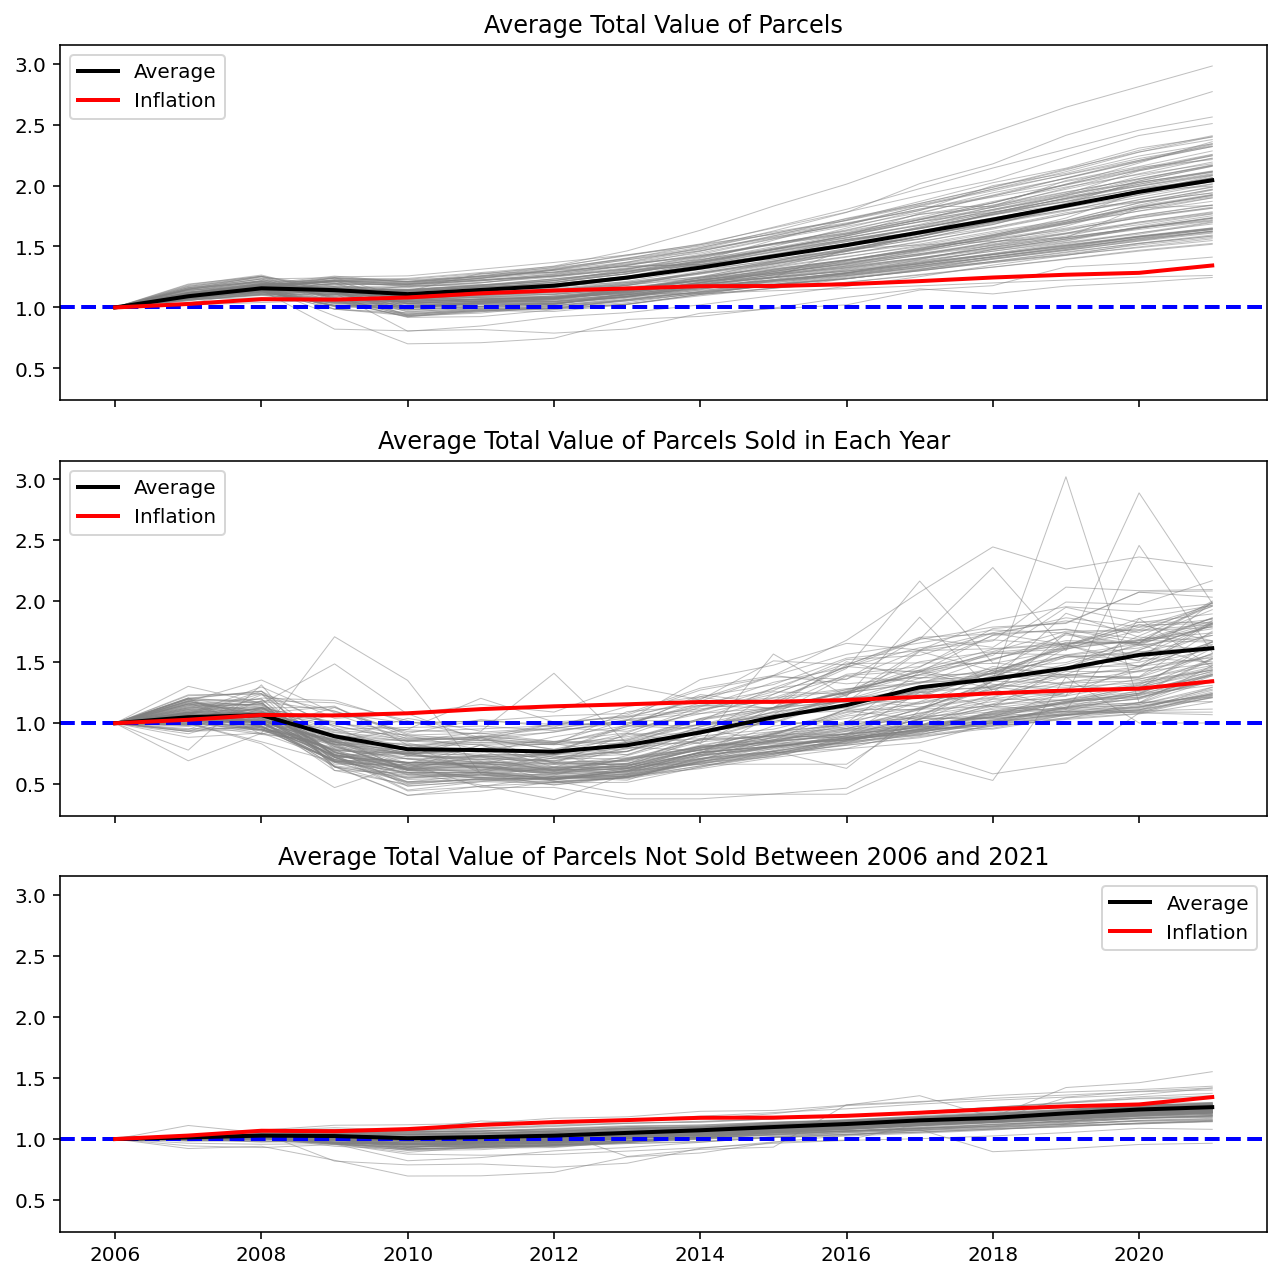

In [61]:
df_LAcity_parcels_TotalValue = pd.read_pickle(f"{local_dir}/dataframe/df_LAcity_parcels_TotalValue.pkl").fillna(method="ffill")
df_LAcity_parcels_TotalValueSold = pd.read_pickle(f"{local_dir}/dataframe/df_LAcity_parcels_TotalValueSold.pkl").fillna(method="ffill")
df_LAcity_parcels_TotalValueNotSold = pd.read_pickle(f"{local_dir}/dataframe/df_LAcity_parcels_TotalValueNotSold.pkl").fillna(method="ffill")
df_LAcity_parcels_Count = pd.read_pickle(f"{local_dir}/dataframe/df_LAcity_parcels_Count.pkl").fillna(method="ffill")
df_LAcity_parcels_CountSold = pd.read_pickle(f"{local_dir}/dataframe/df_LAcity_parcels_CountSold.pkl").fillna(method="ffill")

inflation_rate = pd.read_csv(f"{local_dir}/dataset/USA_inflation.csv").set_index("TIME")["Value"]
value_change = np.ones((len(inflation_rate), 2))
value_change[:,0] = inflation_rate.to_numpy()
for i in range(1, len(inflation_rate)):
    value_change[i,1] = value_change[i-1,1] * (value_change[i,0] * (1/100) + 1)

from matplotlib.cm import get_cmap

cmap = get_cmap("tab20")
colors = cmap.colors
markers = ['o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h',
           'H', 'D', 'd', 'P', 'X', 'o', 'v', '^', '<', '>']

linestyles = ['-', '--', ':', '-.', '-', '--', ':', '-.', '-', '--',
              ':', '-.', '-', '--', ':', '-.', '-', '--', ':', '-.']

f, ax = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True, figsize=(9, 9))
ax[0].set_title(f"Average Total Value of Parcels")
ax[1].set_title(f"Average Total Value of Parcels Sold in Each Year")
ax[2].set_title(f"Average Total Value of Parcels Not Sold Between 2006 and 2021")

# ax[1,1].set_title(f"The Number of Parcels Sold in Each Year")
# ax[1,0].set_xlabel("Roll Year")
# ax[1,1].set_xlabel("Roll Year")
# ax[0,0].set_ylabel("Normalized - Total Value")
# ax[1,0].set_ylabel("Normalized - Count")
# ax[0,0].grid(True, alpha=0.5)
# ax[0,1].grid(True, alpha=0.5)
# ax[1,0].grid(True, alpha=0.5)
# ax[1,1].grid(True, alpha=0.5)

i = 0
count = 0
for neighborhood in df_LAcity_parcels_TotalValue.columns.sort_values():

    i += 1
    if i % 20 == 0:
        i = 0
        count += 1
        rand_color = count 
        rand_marker = count + 1
        rand_linestyle = count + 2
    
    else:
        rand_color = i
        rand_marker = i
        rand_linestyle = i


    ax[0].plot(df_LAcity_parcels_TotalValue.index, df_LAcity_parcels_TotalValue[neighborhood] / df_LAcity_parcels_TotalValue[neighborhood].iloc[0], color="gray", linewidth=0.5, alpha=0.5)

    ax[1].plot(df_LAcity_parcels_TotalValueSold.index, df_LAcity_parcels_TotalValueSold[neighborhood] / df_LAcity_parcels_TotalValueSold[neighborhood].iloc[0], color="gray", linewidth=0.5, alpha=0.5)

    ax[2].plot(df_LAcity_parcels_TotalValueSold.index, df_LAcity_parcels_TotalValueNotSold[neighborhood] / df_LAcity_parcels_TotalValueNotSold[neighborhood].iloc[0], color="gray", linewidth=0.5, alpha=0.5)
    

ax[0].axhline(y=1, color="blue", linestyle="--", linewidth=2)
ax[1].axhline(y=1, color="blue", linestyle="--", linewidth=2)
ax[2].axhline(y=1, color="blue", linestyle="--", linewidth=2)

ax[0].plot(df_LAcity_parcels_TotalValue.index, df_LAcity_parcels_TotalValue.mean(axis=1).values / df_LAcity_parcels_TotalValue.mean(axis=1).values[0], label="Average", color="black", linestyle="-", linewidth=2)

ax[1].plot(df_LAcity_parcels_TotalValueSold.index, df_LAcity_parcels_TotalValueSold.mean(axis=1).values / df_LAcity_parcels_TotalValueSold.mean(axis=1).values[0], label="Average", color="black", linestyle="-", linewidth=2)

ax[2].plot(df_LAcity_parcels_TotalValueSold.index, df_LAcity_parcels_TotalValueNotSold.mean(axis=1).values / df_LAcity_parcels_TotalValueNotSold.mean(axis=1).values[0], label="Average", color="black", linestyle="-", linewidth=2)

ax[0].plot(df_LAcity_parcels_TotalValueSold.index, value_change[:,1], label="Inflation", color="red", linestyle="-", linewidth=2)
ax[1].plot(df_LAcity_parcels_TotalValueSold.index, value_change[:,1], label="Inflation", color="red", linestyle="-", linewidth=2)
ax[2].plot(df_LAcity_parcels_TotalValueSold.index, value_change[:,1], label="Inflation", color="red", linestyle="-", linewidth=2)
ax[0].legend(loc="best")
ax[1].legend(loc="best")
ax[2].legend(loc="best")
# handles, labels = ax[0,1].get_legend_handles_labels()
# f.legend(handles, labels, loc=2, fontsize=14, frameon=True, bbox_to_anchor=(1.04, 1), ncol=4, handleheight=2, borderaxespad=0)
f.tight_layout()
plt.savefig(f"{github_dir}/figures/MB/EDA/LA_city_parcels_normalized_2006_2021.png", dpi=300, bbox_inches="tight")

In [109]:
test = df_LAcity_parcels_TotalValue/ df_LAcity_parcels_TotalValue.iloc[0]
test.loc[2021].mean()

1.9537741477448993

In [62]:
df_LAcity_parcels_TotalValue = pd.read_pickle(f"{local_dir}/dataframe/df_LAcity_parcels_TotalValue.pkl").fillna(method="ffill")
df_LAcity_parcels_TotalValueSold = pd.read_pickle(f"{local_dir}/dataframe/df_LAcity_parcels_TotalValueSold.pkl").fillna(method="ffill")
df_LAcity_parcels_TotalValueNotSold = pd.read_pickle(f"{local_dir}/dataframe/df_LAcity_parcels_TotalValueNotSold.pkl").fillna(method="ffill")
df_LAcity_parcels_Count = pd.read_pickle(f"{local_dir}/dataframe/df_LAcity_parcels_Count.pkl").fillna(method="ffill")
df_LAcity_parcels_CountSold = pd.read_pickle(f"{local_dir}/dataframe/df_LAcity_parcels_CountSold.pkl").fillna(method="ffill")

array([[ 3.225944  ,  1.        ],
       [ 2.852673  ,  1.02852673],
       [ 3.8391    ,  1.0680129 ],
       [-0.3555463 ,  1.06421562],
       [ 1.640043  ,  1.08166921],
       [ 3.156842  ,  1.1158158 ],
       [ 2.069337  ,  1.13890579],
       [ 1.464833  ,  1.15558886],
       [ 1.622223  ,  1.17433509],
       [ 0.1186271 ,  1.17572817],
       [ 1.261583  ,  1.19056095],
       [ 2.13011   ,  1.21592121],
       [ 2.442583  ,  1.2456211 ],
       [ 1.81221   ,  1.26819437],
       [ 1.233584  ,  1.28383861],
       [ 4.697859  ,  1.34415154]])

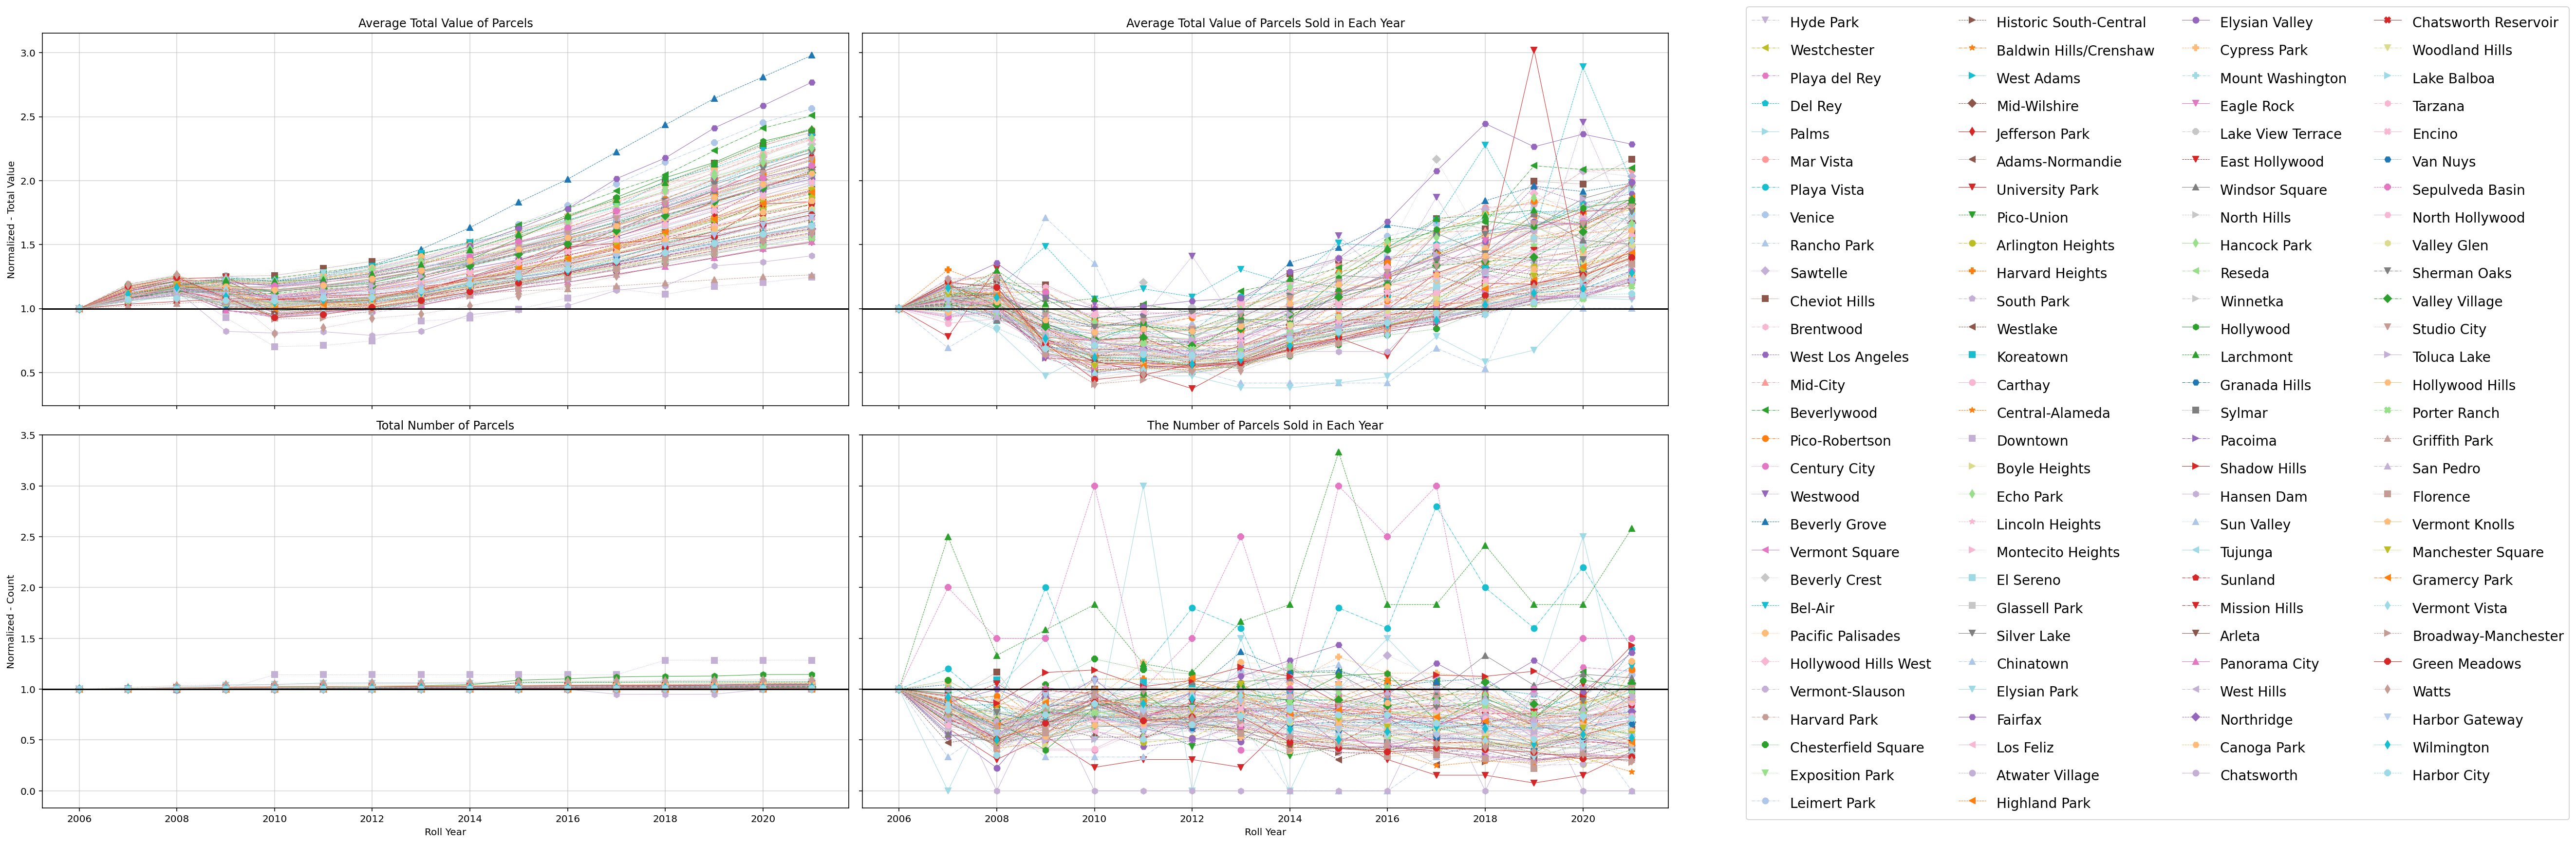

In [4]:
# df_LAcity_parcels_TotalValue = pd.read_pickle(f"{local_dir}/dataframe/df_LAcity_parcels_TotalValue.pkl").fillna(method="ffill")
# df_LAcity_parcels_TotalValueSold = pd.read_pickle(f"{local_dir}/dataframe/df_LAcity_parcels_TotalValueSold.pkl").fillna(method="ffill")
# df_LAcity_parcels_TotalValueNotSold = pd.read_pickle(f"{local_dir}/dataframe/df_LAcity_parcels_TotalValueSold.pkl").fillna(method="ffill")
# df_LAcity_parcels_Count = pd.read_pickle(f"{local_dir}/dataframe/df_LAcity_parcels_Count.pkl").fillna(method="ffill")
# df_LAcity_parcels_CountSold = pd.read_pickle(f"{local_dir}/dataframe/df_LAcity_parcels_CountSold.pkl").fillna(method="ffill")

# from matplotlib.cm import get_cmap

# cmap = get_cmap("tab20")
# colors = cmap.colors
# markers = ['o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h',
#            'H', 'D', 'd', 'P', 'X', 'o', 'v', '^', '<', '>']

# linestyles = ['-', '--', ':', '-.', '-', '--', ':', '-.', '-', '--',
#               ':', '-.', '-', '--', ':', '-.', '-', '--', ':', '-.']

# f, ax = plt.subplots(nrows=2, ncols=2, sharex="col", sharey="row", figsize=(24, 12))
# ax[0,0].set_title(f"Average Total Value of Parcels")
# ax[1,0].set_title(f"Total Number of Parcels")
# ax[0,1].set_title(f"Average Total Value of Parcels Sold in Each Year")
# ax[1,1].set_title(f"The Number of Parcels Sold in Each Year")
# ax[1,0].set_xlabel("Roll Year")
# ax[1,1].set_xlabel("Roll Year")
# ax[0,0].set_ylabel("Normalized - Total Value")
# ax[1,0].set_ylabel("Normalized - Count")
# ax[0,0].grid(True, alpha=0.5)
# ax[0,1].grid(True, alpha=0.5)
# ax[1,0].grid(True, alpha=0.5)
# ax[1,1].grid(True, alpha=0.5)

# for neighborhood in df_LAcity_parcels_TotalValue.columns:
#     rand_color = np.random.randint(20, size=1)[0]
#     rand_marker = np.random.randint(20, size=1)[0]
#     rand_linestyle = np.random.randint(20, size=1)[0]

#     ax[0,0].plot(df_LAcity_parcels_TotalValue.index, df_LAcity_parcels_TotalValue[neighborhood] / df_LAcity_parcels_TotalValue[neighborhood].iloc[0], label=neighborhood, color=colors[rand_color], marker=markers[rand_marker], linestyle=linestyles[rand_linestyle], linewidth=0.5)

#     ax[1,0].plot(df_LAcity_parcels_Count.index, df_LAcity_parcels_Count[neighborhood] / df_LAcity_parcels_Count[neighborhood].iloc[0], label=neighborhood, color=colors[rand_color], marker=markers[rand_marker], linestyle=linestyles[rand_linestyle], linewidth=0.5)

#     ax[0,1].plot(df_LAcity_parcels_TotalValueSold.index, df_LAcity_parcels_TotalValueSold[neighborhood] / df_LAcity_parcels_TotalValueSold[neighborhood].iloc[0], label=neighborhood, color=colors[rand_color], marker=markers[rand_marker], linestyle=linestyles[rand_linestyle], linewidth=0.5)

#     ax[1,1].plot(df_LAcity_parcels_CountSold.index, df_LAcity_parcels_CountSold[neighborhood] / df_LAcity_parcels_CountSold[neighborhood].iloc[0], label=neighborhood, color=colors[rand_color], marker=markers[rand_marker], linestyle=linestyles[rand_linestyle], linewidth=0.5)
    
#     ax[0,0].axhline(y=1, color="black")
#     ax[0,1].axhline(y=1, color="black")
#     ax[1,0].axhline(y=1, color="black")
#     ax[1,1].axhline(y=1, color="black")


# handles, labels = ax[0,1].get_legend_handles_labels()
# f.legend(handles, labels, loc=2, fontsize=14, frameon=True, bbox_to_anchor=(1.04, 1), ncol=4, handleheight=2, borderaxespad=0)
# f.tight_layout()
# plt.savefig(f"{github_dir}/figures/MB/EDA/LA_city_parcels_normalized.png", dpi=300, bbox_inches="tight")

## 4.4. Plot the most recent average TotalValue for each neighborhood

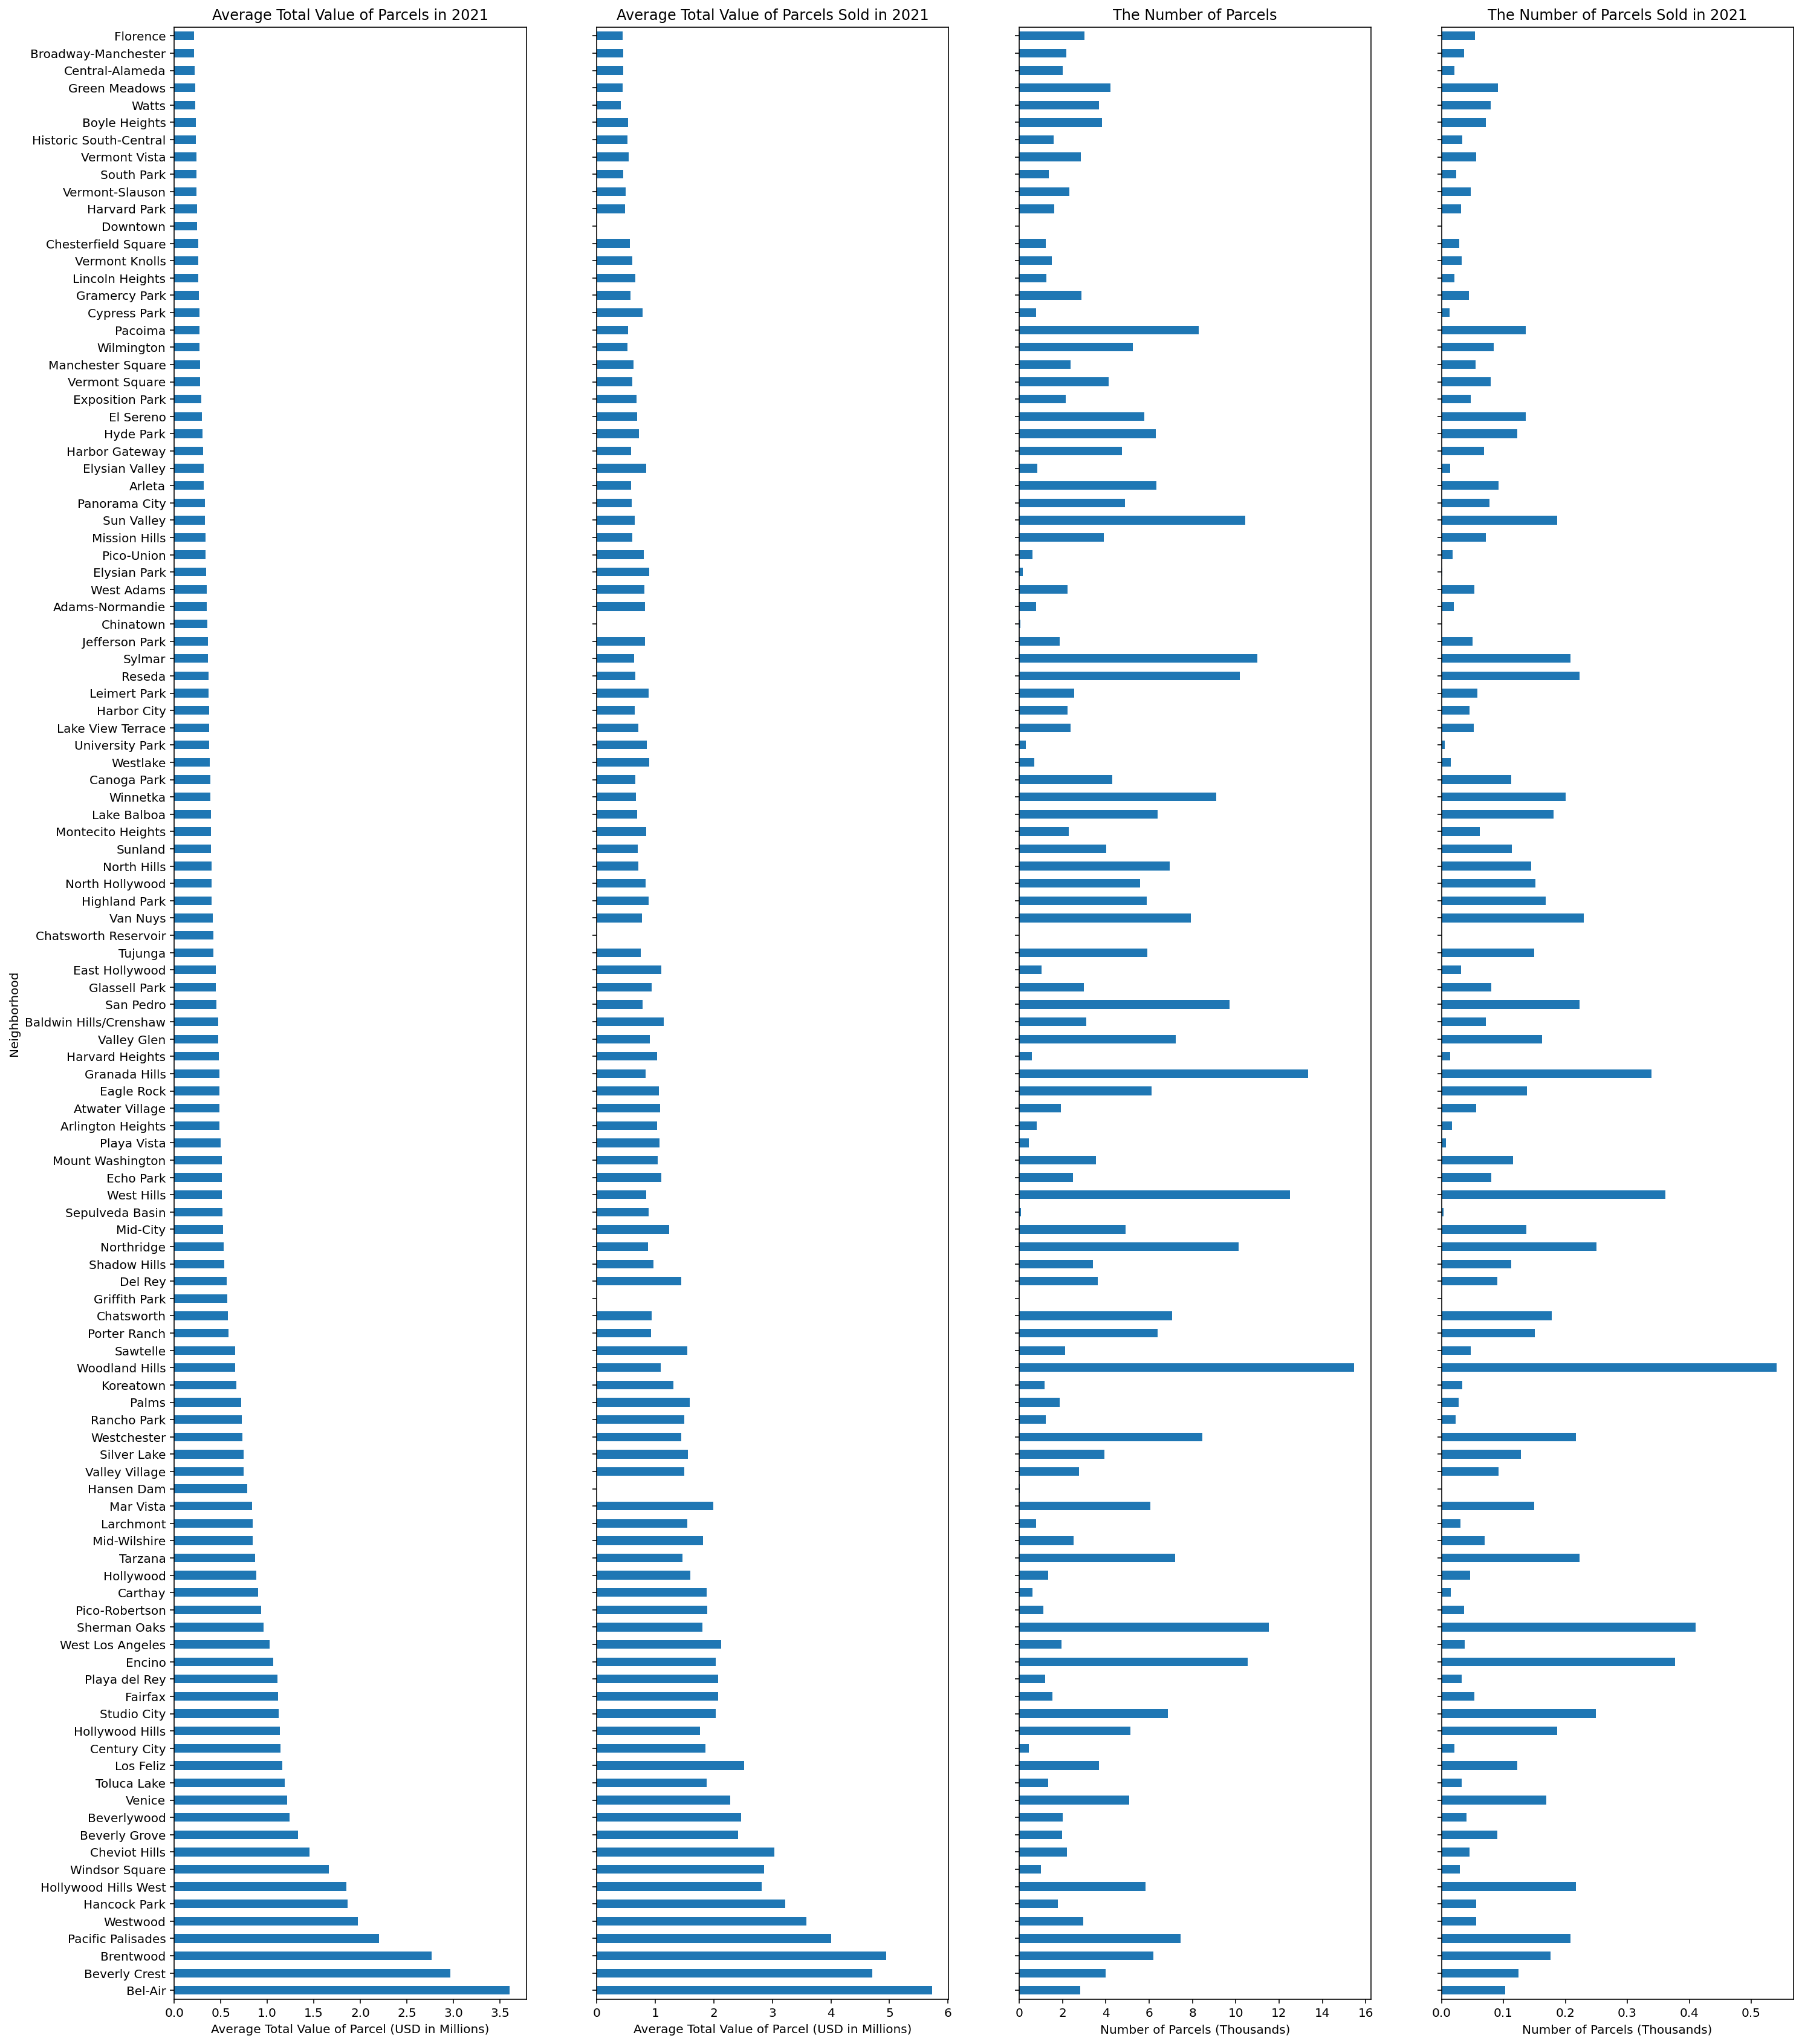

In [237]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(24,30))

df_LAcity_parcels_EDA[df_LAcity_parcels_EDA["RollYear"] == 2021].groupby("Neighborhood").agg({"TotalValue": "mean"}).sort_values(by="TotalValue", ascending=False).div(1e6).reset_index().plot(ax=ax1, kind="bar", x="Neighborhood", y="TotalValue", legend=False)

index_ax1 = df_LAcity_parcels_EDA[df_LAcity_parcels_EDA["RollYear"] == 2021].groupby("Neighborhood").agg({"TotalValue": "mean"}).sort_values(by="TotalValue", ascending=False).index

df_LAcity_parcels_EDA[(df_LAcity_parcels_EDA["RollYear"] == 2021) & (df_LAcity_parcels_EDA["LandBaseYear"] == 2021)].groupby("Neighborhood").agg({"TotalValue": "mean"}).reindex(index_ax1).div(1e6).reset_index().plot(ax=ax2, kind="bar", x="Neighborhood", y="TotalValue", legend=False)

df_LAcity_parcels_EDA[df_LAcity_parcels_EDA["RollYear"] == 2021].groupby("Neighborhood").agg({"AIN": "count"}).reindex(index_ax1).div(1e3).reset_index().plot(ax=ax3, kind="bar", x="Neighborhood", y="AIN", legend=False)

df_LAcity_parcels_EDA[(df_LAcity_parcels_EDA["RollYear"] == 2021) & (df_LAcity_parcels_EDA["LandBaseYear"] == 2021)].groupby("Neighborhood").agg({"AIN": "count"}).reindex(index_ax1).div(1e3).reset_index().plot(ax=ax4, kind="bar", x="Neighborhood", y="AIN", legend=False)

ax1.set_xlabel("Average Total Value of Parcel (USD in Millions)")
ax2.set_xlabel("Average Total Value of Parcel (USD in Millions)")
ax3.set_xlabel("Number of Parcels (Thousands)")
ax4.set_xlabel("Number of Parcels (Thousands)")
ax1.set_title("Average Total Value of Parcels in 2021")
ax2.set_title("Average Total Value of Parcels Sold in 2021")
ax3.set_title("The Number of Parcels")
ax4.set_title("The Number of Parcels Sold in 2021");
plt.savefig(f"{github_dir}/figures/MB/EDA/LA_city_parcels_2021_overview.png", dpi=300, bbox_inches="tight")